Merged rows (before dropna): (124, 6)
Merged rows (after dropna): (13, 6)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/faitusjelinejoseph/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


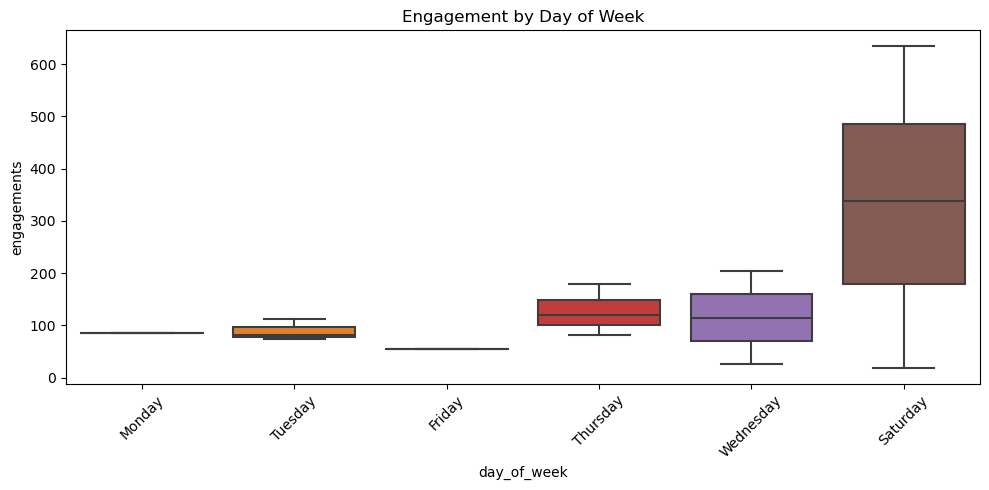

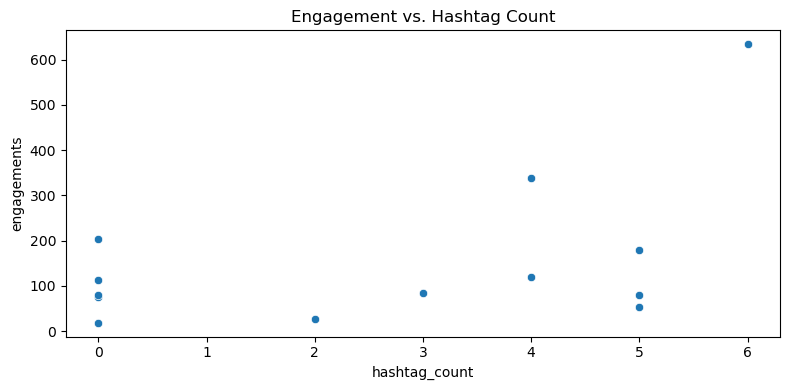

Final dataset exported to: final_merged_social_data.csv

 Sample Output:
     post_date    museum_name  \
1   2024-04-15  Ulster Museum   
11  2024-04-30  Ulster Museum   
19  2024-05-24  Ulster Museum   
27  2024-07-04  Ulster Museum   
34  2024-07-31  Ulster Museum   

                                              caption  platform  engagements  \
1   Around 60 people from different communities to...  facebook         85.0   
11  Important visitor notice for Wednesday 1st May...  facebook         75.0   
19  Discover Caravaggio's 'The Supper at Emmaus', ...  facebook         54.0   
27  The Supper at Emmaus by Caravaggio, depicts th...  facebook        120.0   
34  Go for Gold! Congratulations to Daniel Wiffen,...  facebook        204.0   

      reach  hashtag_count day_of_week  month  sentiment  
1    1059.0              3      Monday      4     0.9758  
11   2228.0              0     Tuesday      4     0.5423  
19   2401.0              5      Friday      5     0.6597  
27   7320.0

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Load Data
# -----------------------------
fb_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Final_Facebook_Posts_With_Captions.xlsx"
ig_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Instagram captions.xlsx"
report_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Digital Engagement Report 2024-25.xlsx"

fb_df = pd.read_excel(fb_path, sheet_name='Sheet1')
ig_df = pd.read_excel(ig_path, sheet_name='Sheet1')
report_data = pd.read_excel(report_path, sheet_name=None)
activity_df = report_data['Social Activity Tracker']

# -----------------------------
# 2. Clean Facebook & Instagram
# -----------------------------
fb_df_cleaned = fb_df.rename(columns={
    'Post Date': 'post_date',
    'Museum Name': 'museum_name',
    'Formatted Facebook Caption': 'caption'
})
fb_df_cleaned['platform'] = 'facebook'

ig_df_cleaned = ig_df.rename(columns={
    'Date Posted': 'post_date',
    'Museum Site': 'museum_name',
    'Full Caption': 'caption'
})
ig_df_cleaned['platform'] = 'instagram'

fb_df_cleaned = fb_df_cleaned[['post_date', 'museum_name', 'caption', 'platform']]
ig_df_cleaned = ig_df_cleaned[['post_date', 'museum_name', 'caption', 'platform']]
combined_posts = pd.concat([fb_df_cleaned, ig_df_cleaned], ignore_index=True)

combined_posts['post_date'] = pd.to_datetime(combined_posts['post_date'], errors='coerce').dt.date
combined_posts = combined_posts.dropna(subset=['caption', 'post_date'])

# -----------------------------
# 3. Clean Engagement Report
# -----------------------------
activity_df_cleaned = activity_df.rename(columns={
    'Day': 'day',
    'Month': 'month',
    'Site': 'site',
    'Content Type': 'content_type',
    'Total Active Engagements (Like, Comment, Share, Video >15s)': 'engagements',
    'Total Reach': 'reach'
}).dropna(subset=['site', 'month'])

activity_df_cleaned = activity_df_cleaned[~activity_df_cleaned['site'].isin(['NNMI'])]

month_str_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
activity_df_cleaned['month'] = activity_df_cleaned['month'].map(month_str_to_num)
activity_df_cleaned['day'] = activity_df_cleaned['day'].fillna(15).astype(int)
activity_df_cleaned['post_date'] = pd.to_datetime({
    'year': 2024,
    'month': activity_df_cleaned['month'],
    'day': activity_df_cleaned['day']
}, errors='coerce').dt.date

site_to_museum = {
    'UM': 'Ulster Museum',
    'UTM': 'Ulster Transport Museum',
    'UAFP': 'Ulster American Folk Park',
    'AFP': 'Ulster American Folk Park',
    'UFM': 'Ulster Folk Museum'
}
activity_df_cleaned['museum_name'] = activity_df_cleaned['site'].map(site_to_museum)
activity_df_cleaned['platform'] = activity_df_cleaned['content_type'].apply(
    lambda x: 'facebook' if isinstance(x, str) and 'Facebook' in x else 'instagram'
)

# -----------------------------
# 4. Merge Datasets
# -----------------------------
merged_df = pd.merge(
    combined_posts,
    activity_df_cleaned[['post_date', 'museum_name', 'platform', 'engagements', 'reach']],
    on=['post_date', 'museum_name', 'platform'],
    how='left'
)
print("Merged rows (before dropna):", merged_df.shape)

merged_df = merged_df.dropna(subset=['engagements'])
print("Merged rows (after dropna):", merged_df.shape)

# -----------------------------
# 5. Feature Engineering
# -----------------------------
merged_df['hashtag_count'] = merged_df['caption'].fillna('').apply(lambda x: x.count('#'))
merged_df['hour_of_day'] = 0  # No timestamp info
merged_df['day_of_week'] = pd.to_datetime(merged_df['post_date']).dt.day_name()
merged_df['month'] = pd.to_datetime(merged_df['post_date']).dt.month

# Sentiment Analysis
nltk.download('vader_lexicon')  # <- Only needed once
sia = SentimentIntensityAnalyzer()
merged_df['sentiment'] = merged_df['caption'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

# -----------------------------
# 6. Visualizations
# -----------------------------
if not merged_df.empty:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='day_of_week', y='engagements', data=merged_df)
    plt.title('Engagement by Day of Week')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='hashtag_count', y='engagements', data=merged_df)
    plt.title('Engagement vs. Hashtag Count')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")

# -----------------------------
# 7. Export Cleaned Dataset
# -----------------------------
merged_df.to_csv("/Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv", index=False)
print("Final dataset exported to: final_merged_social_data.csv")

# -----------------------------
# 8. Preview
# -----------------------------
print("\n Sample Output:")
print(merged_df[['post_date', 'museum_name', 'caption', 'platform', 'engagements', 'reach', 'hashtag_count', 'day_of_week', 'month', 'sentiment']].head())


In [11]:
# =============================
# 9) Model-ready features
# =============================
# Silence warnings/log spam
import os, warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")                       # blanket
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ["PYTHONWARNINGS"] = "ignore"

df = merged_df.copy()

# Extra lightweight text/structure features
def count_emojis(text):
    if not isinstance(text, str): return 0
    # crude emoji proxy: anything outside basic Latin or common punct
    return len(re.findall(r"[^\w\s#@.,!?'\-:;()/&]", text))

df['caption'] = df['caption'].fillna('')
df['caption_len'] = df['caption'].apply(len)
df['word_count'] = df['caption'].apply(lambda x: len(x.split()))
df['emoji_count'] = df['caption'].apply(count_emojis)

# Target (log transform stabilizes variance for count-like data)
y = np.log1p(df['engagements'].astype(float))

# Feature sets
text_col = 'caption'
cat_cols  = ['museum_name', 'platform', 'day_of_week', 'month']  # treat month as categorical
num_cols  = ['hashtag_count', 'sentiment', 'caption_len', 'word_count', 'emoji_count']

# Train/valid split
X_train, X_test, y_train, y_test = train_test_split(
    df[[text_col] + cat_cols + num_cols],
    y,
    test_size=0.2,
    random_state=42
)

# =============================
# 10) Preprocessing + Model
# =============================
text_vec = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    lowercase=True,
)

cat_enc = OneHotEncoder(handle_unknown='ignore', sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ('text', text_vec, text_col),
        ('cat',  cat_enc, cat_cols),
        ('num',  'passthrough', num_cols),
    ],
    remainder='drop',
    sparse_threshold=0.3
)

model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    verbosity=-1   # <- quiet LightGBM
)

pipe = Pipeline([
    ('prep', preprocess),
    ('model', model)
])

# =============================
# 11) Model selection (random search)
# =============================
param_dist = {
    'model__n_estimators': [200, 400, 600, 800],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__num_leaves': [31, 63, 127],
    'model__max_depth': [-1, 6, 8, 10],
    'model__min_child_samples': [10, 20, 30, 50],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0.0, 0.1, 0.3],
    'model__reg_lambda': [0.0, 0.5, 1.0],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    verbose=0      # <- no progress prints
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search.fit(X_train, y_train)
    

search.fit(X_train, y_train)
best_pipe = search.best_estimator_
print("Best params:", search.best_params_)

# =============================
# 12) Evaluation (on original scale)
# =============================
y_pred_log = best_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)         # invert the log1p
y_true = np.expm1(y_test.to_numpy())

rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:,.2f}")
print(f"Test MAE : {mae:,.2f}")
print(f"Test R^2 : {r2:.4f}")

# =============================
# 13) Feature importance (global)
# =============================
# Map transformer output to feature names so importances are interpretable
def get_feature_names_from_ct(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            # OneHotEncoder expects original column names
            if isinstance(trans, OneHotEncoder):
                feats = trans.get_feature_names_out(cols)
            else:
                feats = trans.get_feature_names_out()
            names.extend(list(feats))
        elif trans == 'passthrough':
            # passthrough → original column names
            if isinstance(cols, list):
                names.extend(cols)
            else:
                names.append(cols)
        else:
            # fallback
            if isinstance(cols, list):
                names.extend([f"{name}__{c}" for c in cols])
            else:
                names.append(f"{name}__{cols}")
    return np.array(names)

lgbm = best_pipe.named_steps['model']
ct   = best_pipe.named_steps['prep']
feat_names = get_feature_names_from_ct(ct)

importances = pd.DataFrame({
    'feature': feat_names,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 25 features by importance:")
print(importances.head(25))

# Optional: save artifacts
# output_dir = "/Users/faitusjelinejoseph/Documents/Project/Social"
# importances.to_csv(f"{output_dir}/lgbm_feature_importance.csv", index=False)
# joblib.dump(best_pipe, f"{output_dir}/social_lgbm_pipeline.pkl")

# =============================
# 14) Optimal hashtags (data-driven)
# =============================
def extract_hashtags(text):
    if not isinstance(text, str): return []
    # normalize to lowercase; keep alnum/underscore after '#'
    return [h.lower() for h in re.findall(r'#\w+', text)]

tag_df = df[['caption', 'engagements', 'museum_name', 'platform', 'day_of_week', 'month']].copy()
tag_df['hashtags'] = tag_df['caption'].apply(extract_hashtags)
tag_exp = tag_df.explode('hashtags').dropna(subset=['hashtags'])

counts = tag_exp.groupby('hashtags').size().rename('count')
means  = tag_exp.groupby('hashtags')['engagements'].mean().rename('avg_engagement')
tag_stats = pd.concat([counts, means], axis=1).reset_index()


# =============================
# 15) Best posting day per museum
# =============================
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=dow_order, ordered=True)

day_stats = (
    df.groupby(['museum_name','day_of_week'])
      .agg(avg_engagement=('engagements','mean'), posts=('engagements','size'))
      .reset_index()
      .sort_values(['museum_name','avg_engagement'], ascending=[True, False])
)

# Best day per museum (with number of posts backing it)
best_day_idx = day_stats.groupby('museum_name')['avg_engagement'].idxmax()
best_days = day_stats.loc[best_day_idx].sort_values('avg_engagement', ascending=False)

print("\nBest day per museum (by average engagement):")
print(best_days[['museum_name','day_of_week','avg_engagement','posts']])

# =============================
# 16) Predict for a *new* post (pre-publish)
# =============================
def predict_engagement(caption, museum_name, platform, post_date):
    """
    caption      : str
    museum_name  : one of df['museum_name'].unique()
    platform     : 'facebook' or 'instagram'
    post_date    : 'YYYY-MM-DD' (used to derive day_of_week and month)
    """
    d = pd.to_datetime(post_date)
    row = {
        'caption': caption or "",
        'museum_name': museum_name,
        'platform': platform,
        'day_of_week': d.day_name(),
        'month': d.month,
        'hashtag_count': (caption or "").count('#'),
        'sentiment': sia.polarity_scores(caption or "")['compound'],
        'caption_len': len(caption or ""),
        'word_count': len((caption or "").split()),
        'emoji_count': count_emojis(caption or ""),
    }
    X_new = pd.DataFrame([row])
    pred_log = best_pipe.predict(X_new)[0]
    pred = max(0.0, float(np.expm1(pred_log)))
    return pred




Best params: {'model__subsample': 0.6, 'model__reg_lambda': 0.0, 'model__reg_alpha': 0.0, 'model__num_leaves': 31, 'model__n_estimators': 800, 'model__min_child_samples': 10, 'model__max_depth': -1, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}
Test RMSE: 70.23
Test MAE : 63.40
Test R^2 : -4.4033

Top 25 features by importance:
             feature  importance
0                 00           0
130        read more           0
121               on           0
122           on the           0
123             open           0
124              our           0
125         painting           0
126           please           0
127        presented           0
128     presented by           0
129             read           0
131          rebecca           0
119        of modern           0
132  rebecca laverty           0
133              see           0
134               so           0
135           supper           0
136        supper at           0
137   supperatemmaus       

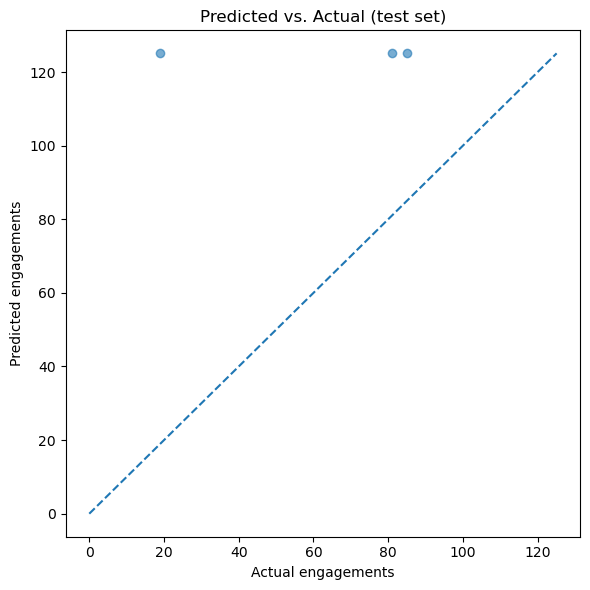

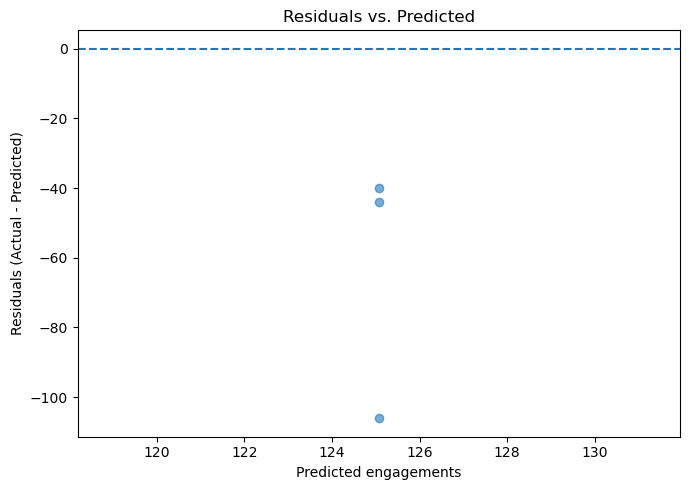

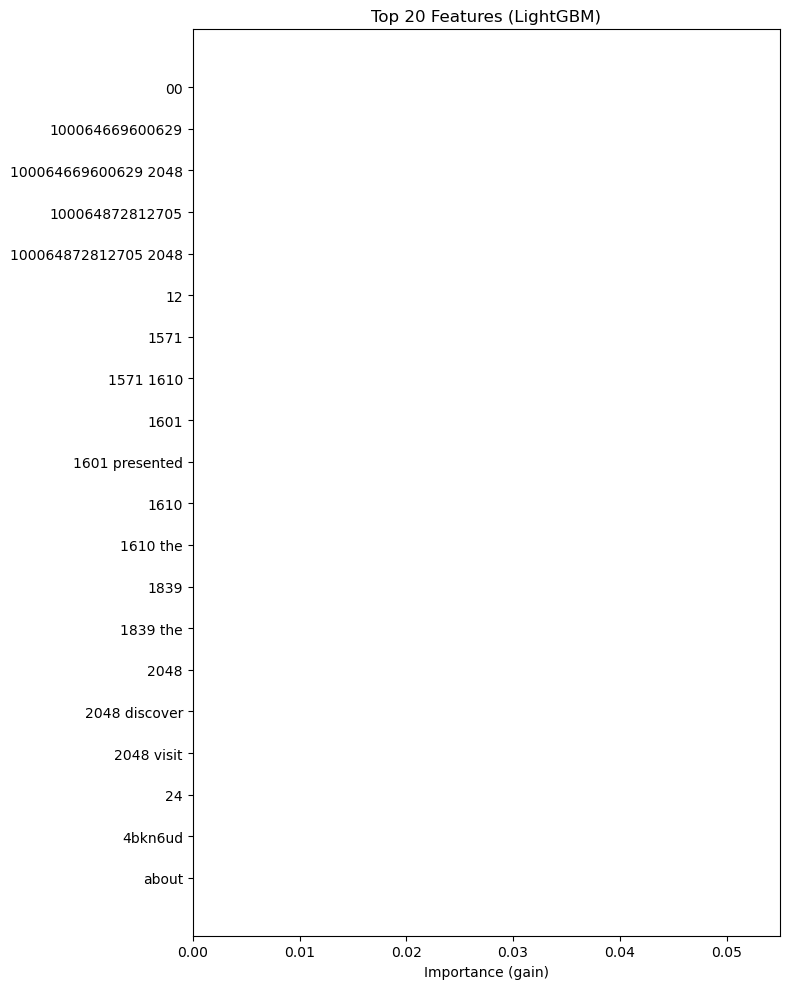

No hashtag stats available to plot (tag_stats empty).


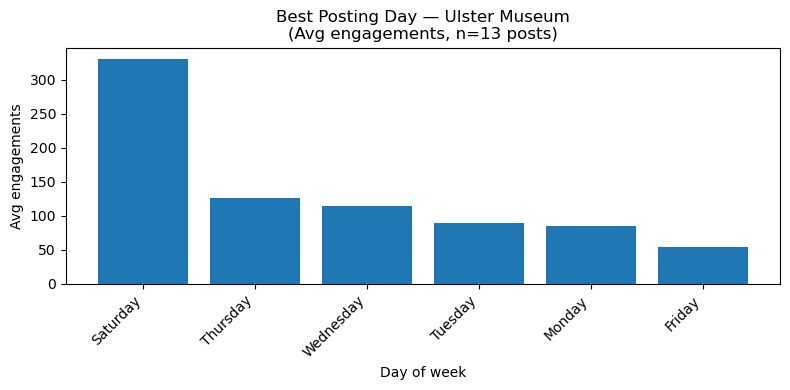

In [9]:
# =============================
# 17) Visualizations  (updated & robust)
# =============================
import os, re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

PLOT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Recompute y_true/y_pred on test for safety (uses best_pipe, X_test, y_test)
y_pred_log = best_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.to_numpy())

# ---- 17.1 Predicted vs. Actual ----
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
mx = max(float(np.max(y_true)), float(np.max(y_pred))) if len(y_true) else 1.0
plt.plot([0, mx], [0, mx], linestyle='--')
plt.xlabel("Actual engagements")
plt.ylabel("Predicted engagements")
plt.title("Predicted vs. Actual (test set)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "predicted_vs_actual.png"), dpi=150)
plt.show()

# ---- 17.2 Residuals vs. Prediction ----
residuals = y_true - y_pred
plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted engagements")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "residuals_vs_predicted.png"), dpi=150)
plt.show()

# ---- 17.3 Top feature importances (robust to gain/permutation/old 'importance') ----
top_n = 20

# pick the most informative DF available
if 'importances_sorted' in globals():
    _imp = importances_sorted.copy()
elif 'importances' in globals():
    _imp = importances.copy()
else:
    _imp = pd.DataFrame(columns=['feature', 'importance'])

if 'perm' in _imp.columns:
    importance_df = _imp[['feature', 'perm']].rename(columns={'perm': 'importance'})
    xlabel = "Importance (permutation)"
elif 'gain' in _imp.columns:
    importance_df = _imp[['feature', 'gain']].rename(columns={'gain': 'importance'})
    xlabel = "Importance (gain)"
elif 'importance' in _imp.columns:
    importance_df = _imp[['feature', 'importance']]
    xlabel = "Importance"
else:
    importance_df = pd.DataFrame({'feature': [], 'importance': []})
    xlabel = "Importance"

top_imp = importance_df.head(top_n).iloc[::-1]  # reverse for horizontal barh
plt.figure(figsize=(8, 0.45 * max(1, len(top_imp)) + 1))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.xlabel(xlabel)
plt.title(f"Top {len(top_imp)} Features (LightGBM)")
plt.xlim(left=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "feature_importance_top.png"), dpi=150)
plt.show()

# ---- 17.4 Best hashtags by average engagement ----
if 'tag_stats' in globals() and isinstance(tag_stats, pd.DataFrame) and not tag_stats.empty:
    top_tags_n = 15
    ts = tag_stats.head(top_tags_n).iloc[::-1]  # highest at top
    plt.figure(figsize=(8, 0.5 * min(top_tags_n, len(ts)) + 1))
    plt.barh(ts["hashtags"], ts["avg_engagement"])
    plt.xlabel("Average engagements")
    plt.title(f"Top {min(top_tags_n, len(ts))} Hashtags (min 5 uses)")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "top_hashtags.png"), dpi=150)
    plt.show()
else:
    print("No hashtag stats available to plot (tag_stats empty).")

# ---- 17.5 Best posting day per museum (historical averages) ----
if 'day_stats' in globals() and isinstance(day_stats, pd.DataFrame) and not day_stats.empty:
    museums = day_stats["museum_name"].dropna().unique().tolist()
    for m in museums:
        sub = day_stats[day_stats["museum_name"] == m].copy()
        if sub.empty:
            continue
        plt.figure(figsize=(8, 4))
        plt.bar(sub["day_of_week"].astype(str), sub["avg_engagement"])
        plt.ylabel("Avg engagements")
        plt.xlabel("Day of week")
        plt.title(f"Best Posting Day — {m}\n(Avg engagements, n={int(sub['posts'].sum())} posts)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        fname = f"best_day_{re.sub(r'[^A-Za-z0-9]+','_', m)}.png"
        plt.savefig(os.path.join(PLOT_DIR, fname), dpi=150)
        plt.show()
else:
    print("No day_stats available to plot.")

# ---- 17.6 What-if: predicted engagement by day-of-week ----
def plot_predicted_by_day(museum_name=None, platform=None, caption="", month=None):
    """
    Month is integer 1-12. If None, uses the most frequent month in your data.
    """
    # sensible defaults
    if museum_name is None:
        museum_name = df["museum_name"].dropna().mode().iloc[0]
    if platform is None:
        platform = df["platform"].dropna().mode().iloc[0]
    if month is None:
        month = int(pd.Series(df["month"]).dropna().mode().iloc[0])

    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    preds = []
    for dname in days:
        # craft a date in the requested month that falls on weekday dname
        base = pd.Timestamp(year=2024, month=int(month), day=1)
        target_idx = days.index(dname)  # 0=Mon..6=Sun
        delta = (target_idx - base.dayofweek) % 7
        date_d = base + pd.Timedelta(days=delta)

        p = predict_engagement(
            caption=caption,
            museum_name=museum_name,
            platform=platform,
            post_date=str(date_d.date())
        )
        preds.append(p)

    plt.figure(figsize=(8, 4))
    plt.bar(days, preds)
    plt.ylabel("Predicted engagements")
    plt.xlabel("Day of week")
    plt.title(f"What-if: Predicted Engagement by Day\n{museum_name} • {platform} • month={month}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "whatif_by_day.png"), dpi=150)
    plt.show()

# ---- 17.7 What-if: predicted engagement vs hashtag count ----
def plot_predicted_vs_hashtags(museum_name=None, platform=None, day_name="Wednesday", month=None, base_caption="Great exhibits today"):
    if museum_name is None:
        museum_name = df["museum_name"].dropna().mode().iloc[0]
    if platform is None:
        platform = df["platform"].dropna().mode().iloc[0]
    if month is None:
        month = int(pd.Series(df["month"]).dropna().mode().iloc[0])

    # craft a date for the chosen weekday
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    base = pd.Timestamp(year=2024, month=int(month), day=1)
    target_wd = days.index(day_name)
    delta = (target_wd - base.dayofweek) % 7
    post_date = str((base + pd.Timedelta(days=delta)).date())

    counts = list(range(0, 16))  # 0..15 hashtags
    preds = []
    for k in counts:
        tags = " ".join([f"#tag{i}" for i in range(1, k+1)])
        cap = (base_caption + " " + tags).strip()
        preds.append(predict_engagement(cap, museum_name, platform, post_date))

    plt.figure(figsize=(8, 4))
    plt.plot(counts, preds, marker='o')
    plt.xlabel("Hashtag count")
    plt.ylabel("Predicted engagements")
    plt.title(f"What-if: Predicted Engagement vs Hashtags\n{museum_name} • {platform} • {day_name} • month={month}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "whatif_vs_hashtags.png"), dpi=150)
    plt.show()

# Example (uncomment to run):
# plot_predicted_by_day(
#     museum_name="Ulster Transport Museum",
#     platform="facebook",
#     caption="Opening weekend! Explore #SteamEngines and #ArtDeco. #MuseumDay",
#     month=11
# )
# plot_predicted_vs_hashtags(
#     museum_name="Ulster Museum",
#     platform="instagram",
#     day_name="Saturday",
#     month=7,
#     base_caption="Family craft workshop this weekend!"
# )


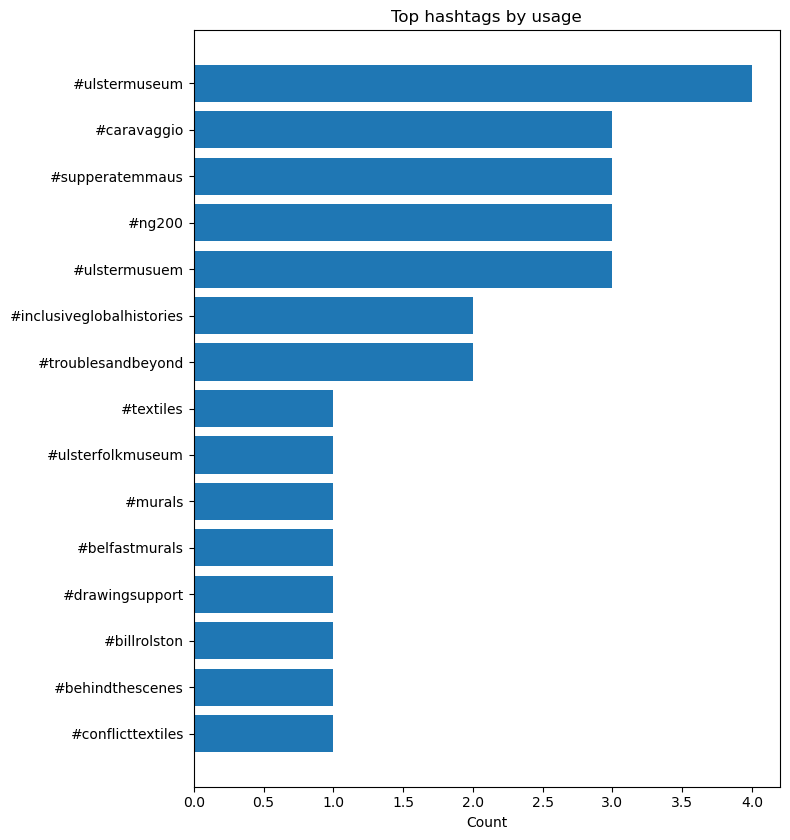

No data for: Top hashtags by avg engagement (≥5 uses)


In [17]:

import matplotlib.pyplot as plt

tmp = df[['caption','engagements']].copy()
tmp['hashtags'] = tmp['caption'].apply(extract_hashtags)
tmp = tmp.explode('hashtags').dropna(subset=['hashtags'])

# Top by usage
top_cnt = (tmp['hashtags'].value_counts()
           .head(15)
           .rename_axis('hashtags')
           .reset_index(name='count'))

# Top by avg engagement (require min uses to reduce noise)
top_avg = (tmp.groupby('hashtags')['engagements']
             .agg(count='size', avg_engagement='mean')
             .query('count >= 5')
             .sort_values(['avg_engagement','count'], ascending=[False, False])
             .head(15)
             .reset_index())

def _barh(df_, x, y, title):
    if df_.empty: 
        print(f"No data for: {title}"); 
        return
    d = df_.iloc[::-1]  # highest at top
    plt.figure(figsize=(8, 0.5*len(d) + 1))
    plt.barh(d[y], d[x])
    plt.xlabel(x.replace('_',' ').title()); plt.title(title)
    plt.xlim(left=0); plt.tight_layout(); plt.show()

_barh(top_cnt, 'count', 'hashtags', 'Top hashtags by usage')
_barh(top_avg, 'avg_engagement', 'hashtags', 'Top hashtags by avg engagement (≥5 uses)')
